In [39]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import pytz
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.mode.chained_assignment = None

In [6]:
#Load data
maradf = pd.read_csv('MARA.csv')
mstrdf = pd.read_csv('MSTR.csv')

<h1>Regression and backtesting functions</h1>

In [150]:
def linear_regression(data,outcome_variable,outcome_ticker):
    #Format data
    cleaned_data = data[['BTC_d','SPY_d',outcome_variable,outcome_ticker,'timestamp']].dropna()
    cleaned_data = cleaned_data.dropna()
    #Define x,y
    x = sm.add_constant(cleaned_data[['SPY_d','BTC_d']])
    y = cleaned_data[outcome_variable]
    #Run regression
    model = sm.OLS(y,x).fit(cov='HC3')
    print(model.summary())
    residuals = model.resid
    fitted = model.fittedvalues
    #Plot residuals
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    sns.scatterplot(x=fitted, y=residuals, ax=axs[0, 0])    #scatterplot pred vs resid
    axs[0, 0].axhline(0, color='red', linestyle='--')
    axs[0, 0].set_title('Predicted Values vs Residuals')
    axs[0, 0].set_xlabel('Predicted Values')
    axs[0, 0].set_ylabel('Residuals')
    sns.histplot(residuals, bins=500, kde=True, ax=axs[0, 1])    #residual histogram
    axs[0, 1].set_title('Residuals Distribution')
    axs[0, 1].set_xlabel('Residuals')
    axs[0, 1].set_ylabel('Frequency')
    axs[0 ,1].set_xlim([-.025,.025])
    sm.qqplot(residuals, line='s', ax=axs[1, 0])     #Q-Q plot
    axs[1, 0].set_title('Q-Q Plot of Residuals')
    #Predict fair value, plot vs actual price
    cleaned_data['pred_price'] = (fitted + 1) * cleaned_data[outcome_ticker].shift(1)
    cleaned_data['difference'] = cleaned_data['pred_price'] - cleaned_data[outcome_ticker]
    sns.histplot(cleaned_data['difference'], bins=500, ax=axs[1, 1])
    axs[1,1].set_title('Predicted Price - Market Price Distribution')
    axs[1,1].set_xlabel('Predicted Price - Market Price')
    axs[1,1].set_ylabel('Frequency')
    axs[1,1].set_xlim([-.25,.25])
    # Adjust layout
    plt.tight_layout()
    plt.show()
    return cleaned_data

In [108]:
def generate_signals(gap,data,ticker):
    data = data.copy()
    data['enter_long'] = np.where(data['pred_price'] >= data[ticker] * (1+gap), 1, 0)
    data['enter_short'] = np.where(data['pred_price'] <= data[ticker] * (1-gap), 1, 0)
    data['hold_long'] = np.where(data['pred_price'] >= data[ticker], 1, 0)
    data['hold_short'] = np.where(data['pred_price'] <= data[ticker], 1, 0)
    return data

In [109]:
def backtest(data,ticker):
    current_status = 'FLAT'
    trades_list = []
    for index, row in data.iterrows():
        if current_status == 'FLAT':
            if row['enter_long'] == 1:
                trades_list.append([row[ticker],1,row['timestamp']])
                current_status = 'LONG'
            elif row['enter_short'] == 1:
                trades_list.append([row[ticker],-1,row['timestamp']])
                current_status = 'SHORT'
        elif current_status == 'LONG':
            if (row['hold_long'] == 0) & (row['enter_short'] == 1):
                trades_list.append([row[ticker],-2,row['timestamp']])
                current_status = 'SHORT'
            elif (row['hold_long'] == 0) & (row['enter_short'] == 0):
                trades_list.append([row[ticker],-1,row['timestamp']])
                current_status = 'FLAT'
        elif current_status == 'SHORT':
            if (row['hold_short'] == 0) & (row['enter_long'] == 1):
                trades_list.append([row[ticker],2,row['timestamp']])
                current_status = 'LONG'
            elif (row['hold_short'] == 0) & (row['enter_short'] == 0):
                trades_list.append([row[ticker],1,row['timestamp']])
                current_status = 'FLAT'
    backtest = pd.DataFrame(trades_list,columns=['price','pos_change','timestamp'])
    backtest['pos'] = backtest['pos_change'].cumsum()
    backtest['profit'] = (backtest['price'].diff() * backtest['pos'].shift()).fillna(0)
    backtest['return'] = backtest['price'].pct_change() * backtest['pos'].shift(1)
    percentage_returns = backtest[backtest['pos'].shift(1) != 0][['return','timestamp']].dropna()
    return percentage_returns

In [110]:
def unix_to_est(unix_ms):
    # Convert Unix timestamp from milliseconds to seconds
    unix_seconds = unix_ms / 1000.0
    # Create a UTC datetime object from the timestamp
    utc_time = datetime.utcfromtimestamp(unix_seconds)
    # Localize the UTC time to UTC timezone
    utc_time = pytz.utc.localize(utc_time)
    # Convert to EST timezone
    est_time = utc_time.astimezone(pytz.timezone('America/New_York'))
    # Return the EST time in a readable format (e.g., 'YYYY-MM-DD HH:MM:SS')
    return est_time.strftime('%Y-%m-%d')

<h1>(MARA) Fair value estimation with SPY and BTC/USD 1min % change</h1>

                            OLS Regression Results                            
Dep. Variable:                 MARA_d   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                 2.751e+04
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:13:06   Log-Likelihood:             8.5537e+05
No. Observations:              189808   AIC:                        -1.711e+06
Df Residuals:                  189805   BIC:                        -1.711e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.508e-06   6.13e-06      1.062      0.2

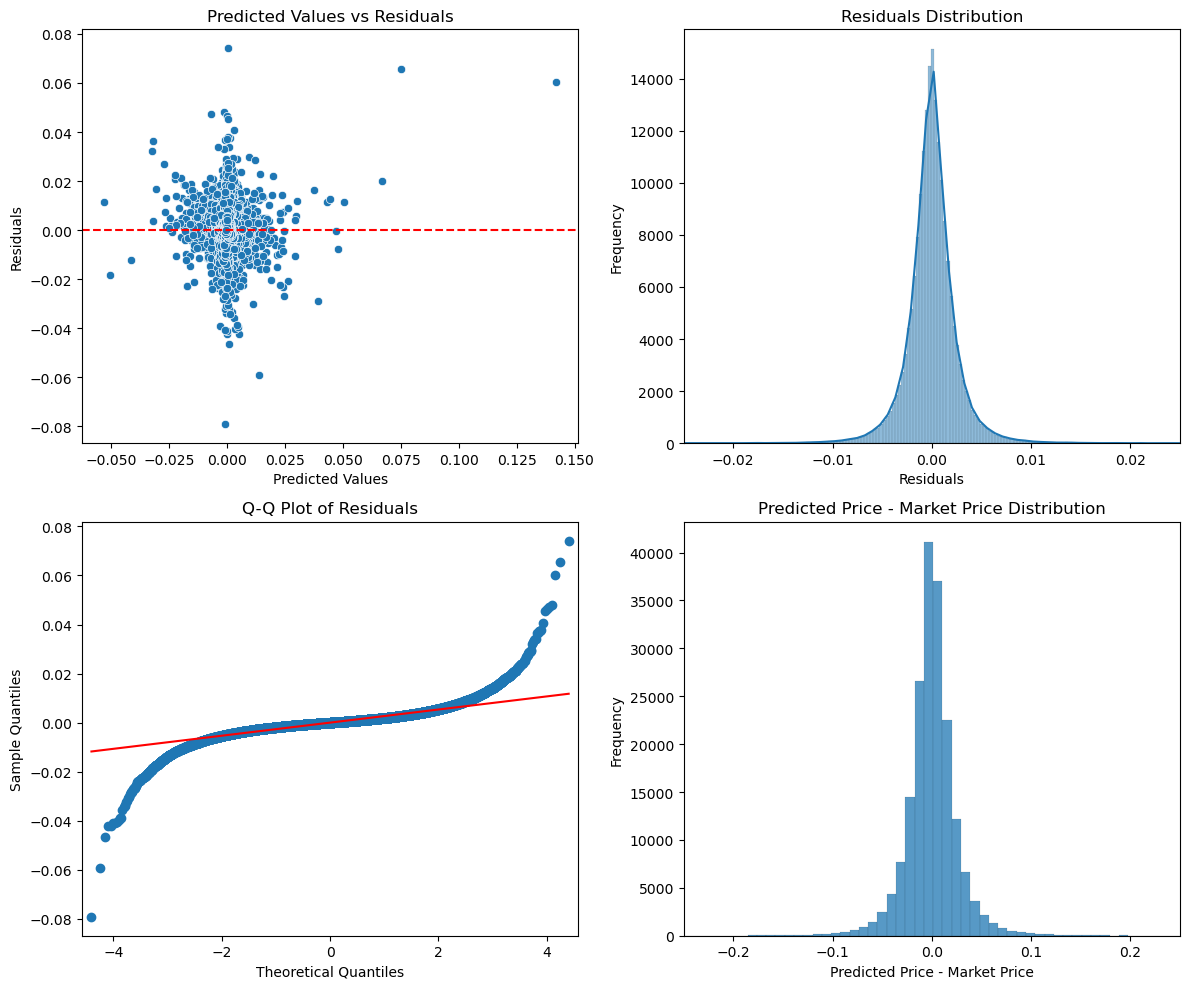

In [151]:
df = linear_regression(maradf,'MARA_d','MARA')

<h1>(MARA) Determine optimal minimum percentage difference in fair value and market price required to enter trade</h1>

100%|██████████| 33/33 [03:48<00:00,  6.92s/it]


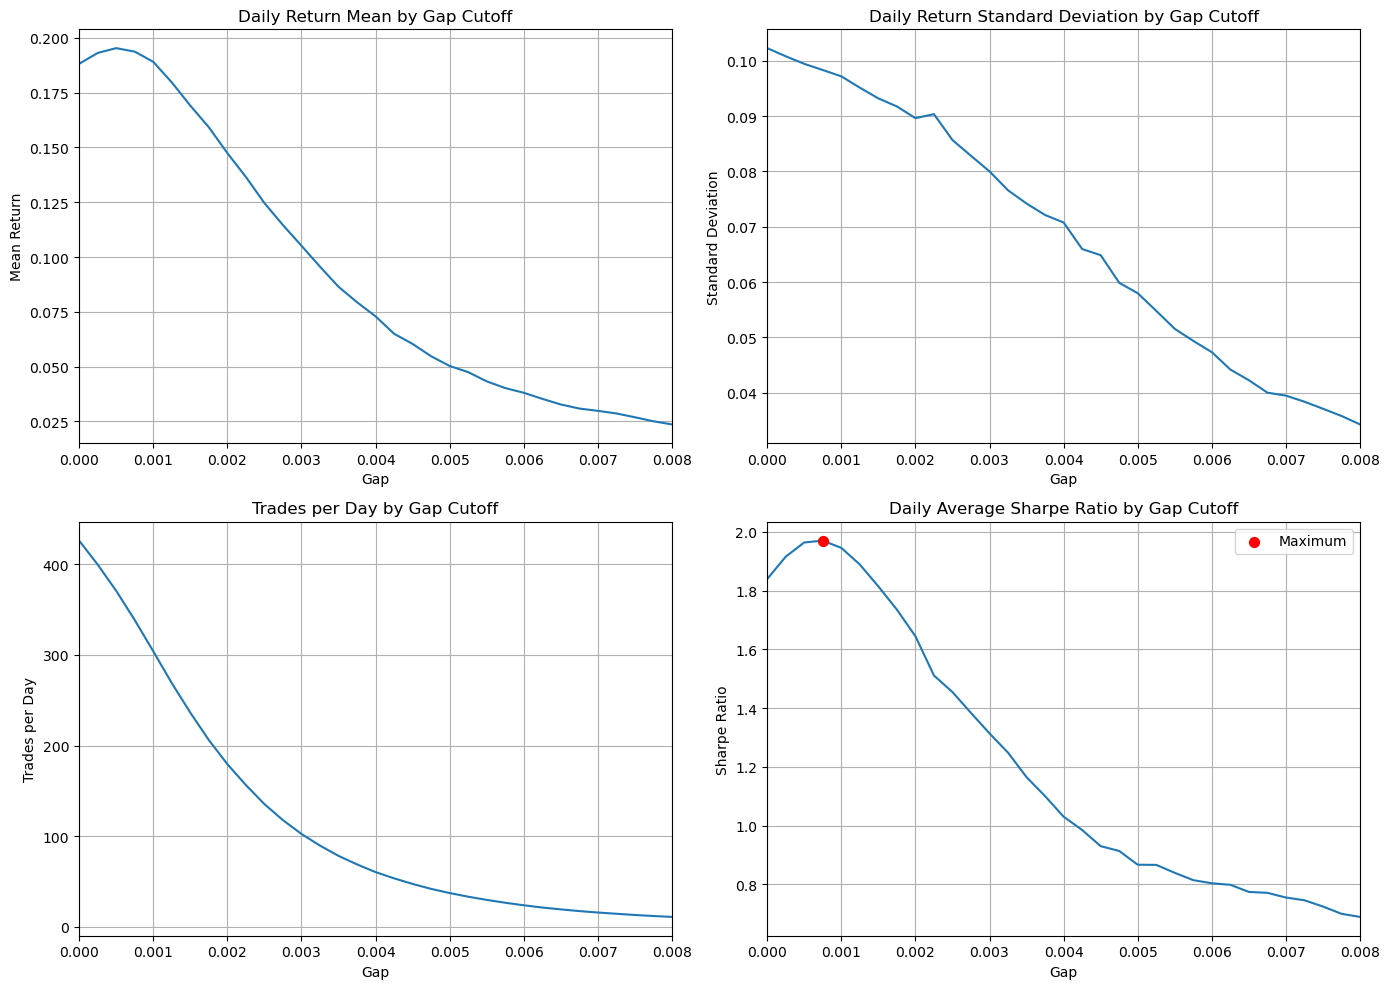

In [102]:
outcome_list = []
for x in tqdm(np.arange(0,0.00825,.00025)):
    pct_returns = backtest(generate_signals(x,df,'MARA'),'MARA')
    pct_returns['date'] = pct_returns['timestamp'].apply(unix_to_est)
    daily_pct_returns = pct_returns.groupby('date')['return'].sum()
    trades_per_day = len(pct_returns)/250
    mean_day = daily_pct_returns.mean()
    std_day = daily_pct_returns.std()
    outcome_list.append([trades_per_day,mean_day,std_day,x])
resultdf = pd.DataFrame(outcome_list,columns=['Trades/Day','Mean/Day','Std/Day','Gap'])
resultdf['Sharpe/Day'] = resultdf['Mean/Day']/resultdf['Std/Day']

#Plot outcome
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Daily Return Mean by Gap Cutoff
axes[0, 0].plot(resultdf['Gap'], resultdf['Mean/Day'])
axes[0, 0].set_title('Daily Return Mean by Gap Cutoff')
axes[0, 0].set_xlabel('Gap')
axes[0, 0].set_ylabel('Mean Return')
axes[0, 0].set_xlim([0, .008])
axes[0, 0].grid()
#Daily Return Standard Deviation by Gap Cutoff
axes[0, 1].plot(resultdf['Gap'], resultdf['Std/Day'])
axes[0, 1].set_title('Daily Return Standard Deviation by Gap Cutoff')
axes[0, 1].set_xlabel('Gap')
axes[0, 1].set_ylabel('Standard Deviation')
axes[0, 1].set_xlim([0, .008])
axes[0, 1].grid()
#Trades per Day by Gap Cutoff
axes[1, 0].plot(resultdf['Gap'], resultdf['Trades/Day'])
axes[1, 0].set_title('Trades per Day by Gap Cutoff')
axes[1, 0].set_xlabel('Gap')
axes[1, 0].set_ylabel('Trades per Day')
axes[1, 0].set_xlim([0, .008])
axes[1, 0].grid()
# Plot 4: Daily Average Sharpe Ratio by Gap Cutoff
axes[1, 1].plot(resultdf['Gap'], resultdf['Sharpe/Day'])
axes[1, 1].scatter(
    resultdf[resultdf['Sharpe/Day'] == resultdf['Sharpe/Day'].max()]['Gap'],
    resultdf[resultdf['Sharpe/Day'] == resultdf['Sharpe/Day'].max()]['Sharpe/Day'],
    marker='o', color='red', s=50, label='Maximum',zorder=2)
axes[1, 1].legend(loc='upper right')
axes[1, 1].set_title('Daily Average Sharpe Ratio by Gap Cutoff')
axes[1, 1].set_xlabel('Gap')
axes[1, 1].set_ylabel('Sharpe Ratio')
axes[1, 1].set_xlim([0, .008])
axes[1, 1].grid()
plt.tight_layout()
plt.show()

<h1>(MARA) Out-of-Sample Testing, Compile Results</h1>

In [121]:
#out of sample results
outdf = pd.read_csv('MARAout.csv').dropna()
outdf['pred_pct_change'] = 0.000006 + (2.1425 * outdf['SPY_d']) + (1.0703 * outdf['BTC_d'])
outdf['pred_price'] = (1 + outdf['pred_pct_change']) * outdf['MARA'].shift(1)
out_pct_returns = backtest(generate_signals(.00075,outdf,'MARA'),'MARA')
out_pct_returns['date'] = out_pct_returns['timestamp'].apply(unix_to_est)
out_daily_pct_returns = out_pct_returns.groupby('date')['return'].sum()
out_trades_per_day = len(out_pct_returns)/186
out_mean_day = out_daily_pct_returns.mean()
out_std_day = out_daily_pct_returns.std()
out_sharpe_day = out_mean_day/out_std_day
#in sample results
indf = pd.read_csv('MARA.csv').dropna()
indf['pred_pct_change'] = 0.000006 + (2.1425 * indf['SPY_d']) + (1.0703 * indf['BTC_d'])
indf['pred_price'] = (1 + indf['pred_pct_change']) * indf['MARA'].shift(1)
in_pct_returns = backtest(generate_signals(.00075,indf,'MARA'),'MARA')
in_pct_returns['date'] = in_pct_returns['timestamp'].apply(unix_to_est)
in_daily_pct_returns = in_pct_returns.groupby('date')['return'].sum()
in_trades_per_day = len(in_pct_returns)/250
in_mean_day = in_daily_pct_returns.mean()
in_std_day = in_daily_pct_returns.std()
in_sharpe_day = in_mean_day/in_std_day

#compile results
final_mara = pd.DataFrame({'In Sample':[in_mean_day,in_std_day,in_sharpe_day,in_trades_per_day],'Out of Sample':[out_mean_day,out_std_day,out_sharpe_day,out_trades_per_day]},
             index=['Mean Daily Return','Daily Standard Deviation','Daily Sharpe Ratio','Trades per Day'])
final_mara

,In Sample,Out of Sample
Mean Daily Return,0.170480,0.109045
Daily Standard Deviation,0.096601,0.081033
Daily Sharpe Ratio,1.764784,1.345693
Trades per Day,306.200000,307.231183


<h1>(MSTR) Fair value estimation with SPY and BTC/USD 1min % change</h1>

                            OLS Regression Results                            
Dep. Variable:                 MSTR_d   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                 1.447e+04
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:13:38   Log-Likelihood:             4.1530e+05
No. Observations:               90654   AIC:                        -8.306e+05
Df Residuals:                   90651   BIC:                        -8.306e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.374e-06   8.23e-06      1.017      0.3

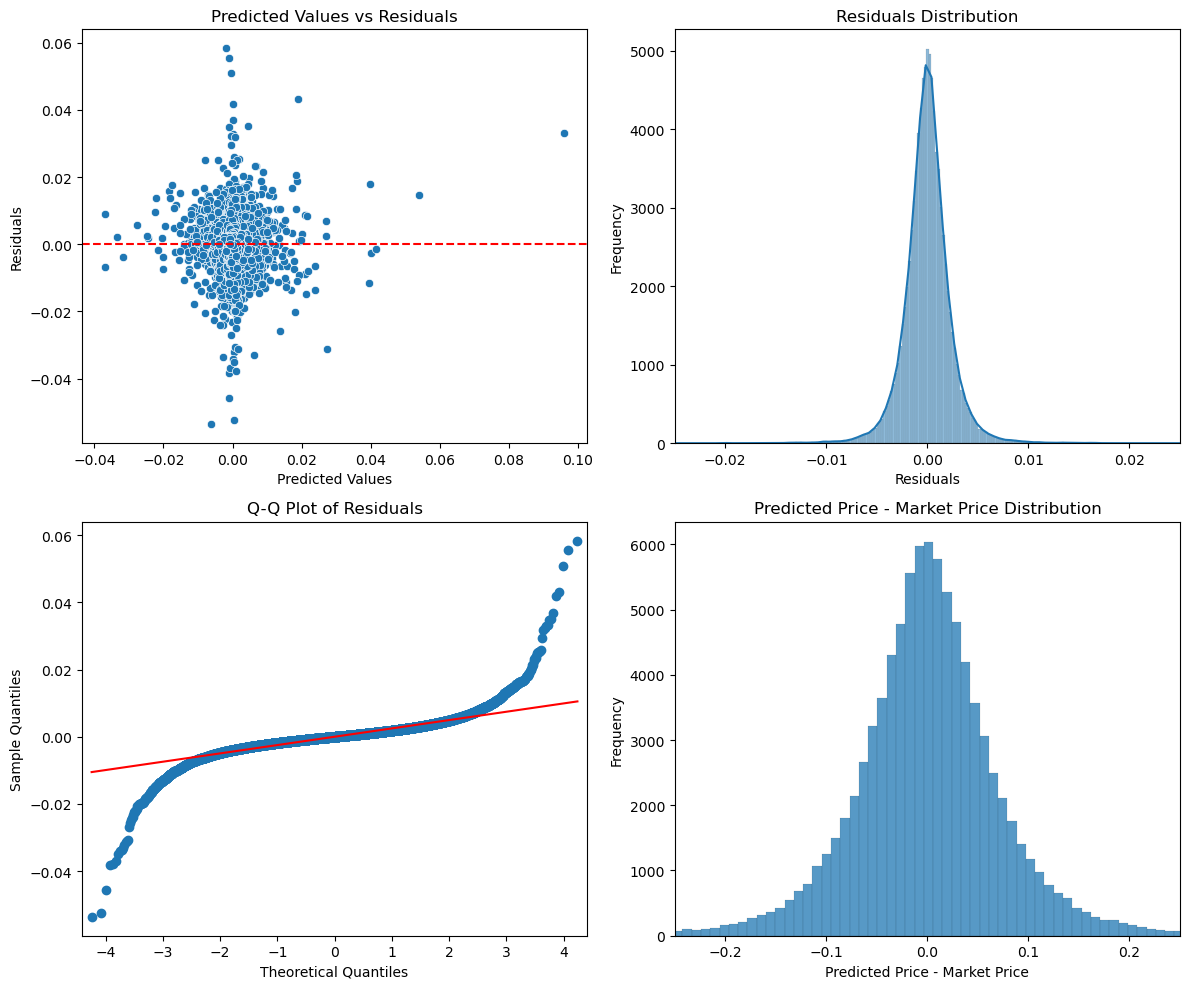

In [152]:
df = linear_regression(mstrdf,'MSTR_d','MSTR')

<h1>(MSTR) Determine optimal minimum percentage difference in fair value and market price required to enter trade</h1>

100%|██████████| 33/33 [01:53<00:00,  3.45s/it]


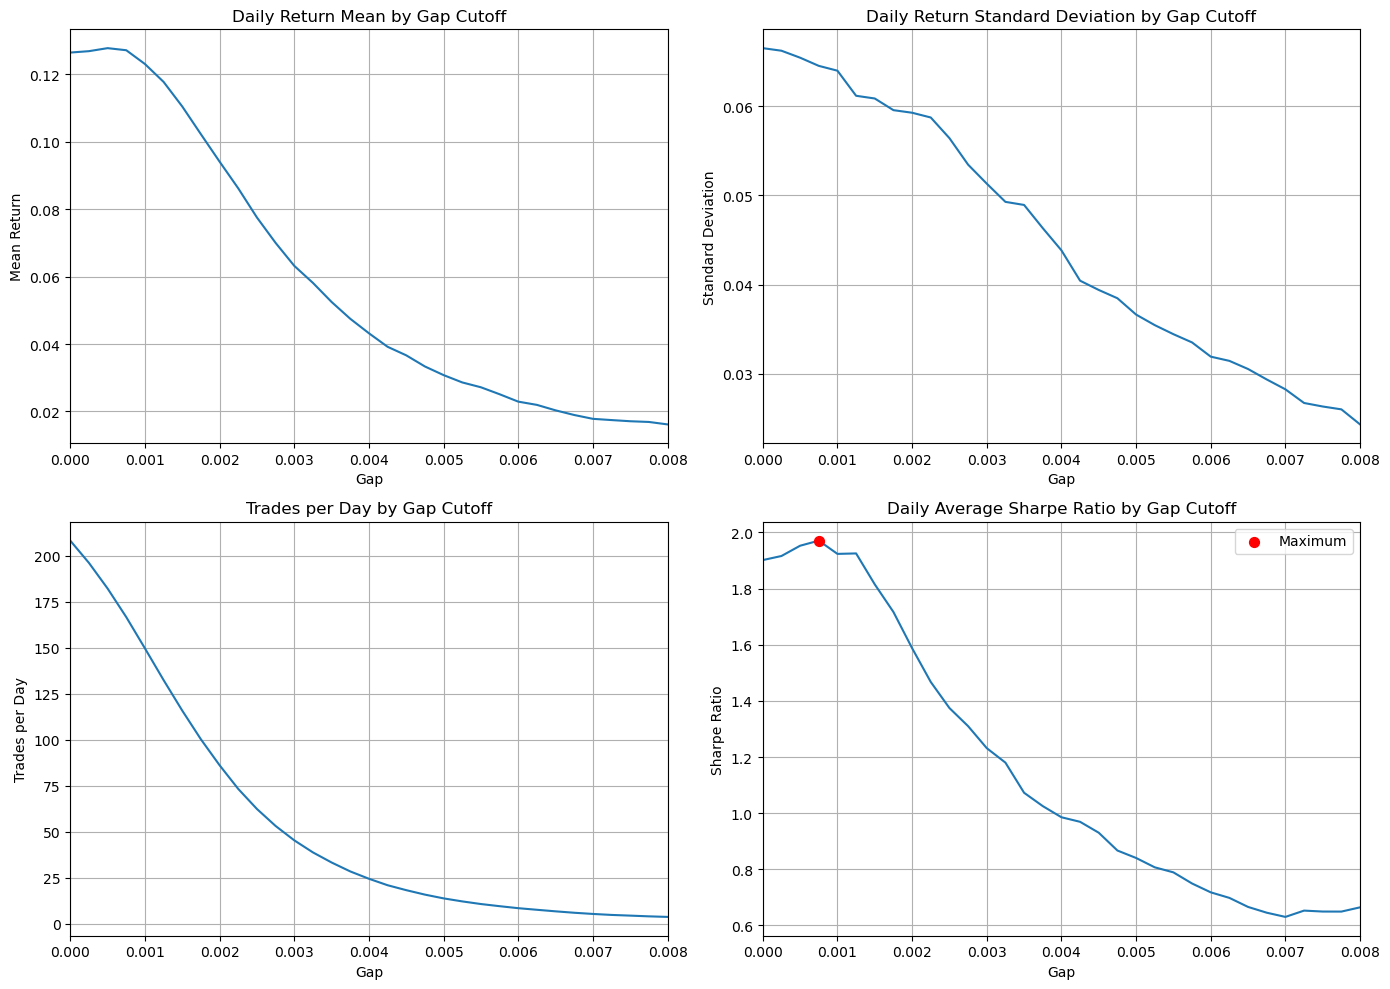

In [106]:
outcome_list = []
for x in tqdm(np.arange(0,0.00825,.00025)):
    pct_returns = backtest(generate_signals(x,df,'MSTR'),'MSTR')
    pct_returns['date'] = pct_returns['timestamp'].apply(unix_to_est)
    daily_pct_returns = pct_returns.groupby('date')['return'].sum()
    trades_per_day = len(pct_returns)/250
    mean_day = daily_pct_returns.mean()
    std_day = daily_pct_returns.std()
    outcome_list.append([trades_per_day,mean_day,std_day,x])
resultdf = pd.DataFrame(outcome_list,columns=['Trades/Day','Mean/Day','Std/Day','Gap'])
resultdf['Sharpe/Day'] = resultdf['Mean/Day']/resultdf['Std/Day']

#Plot outcome
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Daily Return Mean by Gap Cutoff
axes[0, 0].plot(resultdf['Gap'], resultdf['Mean/Day'])
axes[0, 0].set_title('Daily Return Mean by Gap Cutoff')
axes[0, 0].set_xlabel('Gap')
axes[0, 0].set_ylabel('Mean Return')
axes[0, 0].set_xlim([0, .008])
axes[0, 0].grid()
#Daily Return Standard Deviation by Gap Cutoff
axes[0, 1].plot(resultdf['Gap'], resultdf['Std/Day'])
axes[0, 1].set_title('Daily Return Standard Deviation by Gap Cutoff')
axes[0, 1].set_xlabel('Gap')
axes[0, 1].set_ylabel('Standard Deviation')
axes[0, 1].set_xlim([0, .008])
axes[0, 1].grid()
#Trades per Day by Gap Cutoff
axes[1, 0].plot(resultdf['Gap'], resultdf['Trades/Day'])
axes[1, 0].set_title('Trades per Day by Gap Cutoff')
axes[1, 0].set_xlabel('Gap')
axes[1, 0].set_ylabel('Trades per Day')
axes[1, 0].set_xlim([0, .008])
axes[1, 0].grid()
# Plot 4: Daily Average Sharpe Ratio by Gap Cutoff
axes[1, 1].plot(resultdf['Gap'], resultdf['Sharpe/Day'])
axes[1, 1].scatter(
    resultdf[resultdf['Sharpe/Day'] == resultdf['Sharpe/Day'].max()]['Gap'],
    resultdf[resultdf['Sharpe/Day'] == resultdf['Sharpe/Day'].max()]['Sharpe/Day'],
    marker='o', color='red', s=50, label='Maximum',zorder=2)
axes[1, 1].legend(loc='upper right')
axes[1, 1].set_title('Daily Average Sharpe Ratio by Gap Cutoff')
axes[1, 1].set_xlabel('Gap')
axes[1, 1].set_ylabel('Sharpe Ratio')
axes[1, 1].set_xlim([0, .008])
axes[1, 1].grid()
plt.tight_layout()
plt.show()

<h1>(MSTR) Out of Sample Testing, Compile Results</h1>

In [128]:
#out of sample results
outdf = pd.read_csv('MSTRout.csv').dropna()
outdf['pred_pct_change'] = 0.000008 + (1.4899 * outdf['SPY_d']) + (0.7437 * outdf['BTC_d'])
outdf['pred_price'] = (1 + outdf['pred_pct_change']) * outdf['MSTR'].shift(1)
out_pct_returns = backtest(generate_signals(.00075,outdf,'MSTR'),'MSTR')
out_pct_returns['date'] = out_pct_returns['timestamp'].apply(unix_to_est)
out_daily_pct_returns = out_pct_returns.groupby('date')['return'].sum()
out_trades_per_day = len(out_pct_returns)/186
out_mean_day = out_daily_pct_returns.mean()
out_std_day = out_daily_pct_returns.std()
out_sharpe_day = out_mean_day/out_std_day
#in sample results
indf = pd.read_csv('MSTR.csv').dropna()
indf['pred_pct_change'] = 0.000008 + (1.4899 * indf['SPY_d']) + (0.7437 * indf['BTC_d'])
indf['pred_price'] = (1 + indf['pred_pct_change']) * indf['MSTR'].shift(1)
in_pct_returns = backtest(generate_signals(.00075,indf,'MSTR'),'MSTR')
in_pct_returns['date'] = in_pct_returns['timestamp'].apply(unix_to_est)
in_daily_pct_returns = in_pct_returns.groupby('date')['return'].sum()
in_trades_per_day = len(in_pct_returns)/250
in_mean_day = in_daily_pct_returns.mean()
in_std_day = in_daily_pct_returns.std()
in_sharpe_day = in_mean_day/in_std_day

#compile results
final_mara = pd.DataFrame({'In Sample':[in_mean_day,in_std_day,in_sharpe_day,in_trades_per_day],'Out of Sample':[out_mean_day,out_std_day,out_sharpe_day,out_trades_per_day]},
             index=['Mean Daily Return','Daily Standard Deviation','Daily Sharpe Ratio','Trades per Day'])
final_mara

,In Sample,Out of Sample
Mean Daily Return,0.127005,0.127456
Daily Standard Deviation,0.064082,0.073650
Daily Sharpe Ratio,1.981915,1.730571
Trades per Day,165.276000,217.865591
